In [1]:
import torch


assert torch.cuda.is_available(), "CUDA NOT FOUND"

In [2]:
import os


os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
import pandas as pd


train = pd.read_csv('../data/TRAIN.csv').drop('Unnamed: 0', axis=1)
test = pd.read_csv('../data/TEST.csv').drop('Unnamed: 0', axis=1)
validation = pd.read_csv('../data/VALIDATION.csv').drop('Unnamed: 0', axis=1)

In [4]:
train['label'] = 1 - train['label']
test['label'] = 1 - test['label']
validation['label'] = 1 - validation['label']

In [5]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


X = train['text'].to_frame()
y = train['label']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

train_balanced_oversampled = pd.concat([X_resampled, y_resampled], axis=1)
train_balanced_oversampled.columns = ['text', 'label']
train_balanced_oversampled.reset_index(inplace=True, drop='index')

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

train_balanced_undersampled = pd.concat([X_resampled, y_resampled], axis=1)
train_balanced_undersampled.columns = ['text', 'label']
train_balanced_undersampled.reset_index(inplace=True, drop='index')

In [6]:
from datasets import (
    Dataset,
    DatasetDict
)


# oversampling works better
tds = Dataset.from_pandas(train_balanced_oversampled)
testds = Dataset.from_pandas(test)
vds = Dataset.from_pandas(validation)
dataset = DatasetDict()
dataset['train'] = tds
dataset['test'] = testds
dataset['validation'] = vds

In [7]:
from transformers import AutoTokenizer


model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    tokenized = tokenizer(batch["text"], padding=True, truncation=True)
    tokenized['label'] = batch['label']
    return tokenized

dataset_encoded = dataset.map(tokenize, batched=True, batch_size=64, remove_columns=['text'])

Map:   0%|          | 0/150382 [00:00<?, ? examples/s]

Map:   0%|          | 0/12396 [00:00<?, ? examples/s]

Map:   0%|          | 0/12395 [00:00<?, ? examples/s]

In [8]:
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
dataset_encoded.save_to_disk('../data/dataset_encoded_oversampled')

Saving the dataset (0/1 shards):   0%|          | 0/150382 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12396 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/12395 [00:00<?, ? examples/s]

In [9]:
from transformers import DistilBertForSequenceClassification


model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
import numpy as np
from transformers import (
    TrainingArguments,
    Trainer
)


def train(dataset, model, training_args):

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        metrics = {}
        metrics['accuracy'] = (predictions == labels).mean()

        tp = np.sum((predictions == 1) & (labels == 1))
        fp = np.sum((predictions == 1) & (labels == 0))
        fn = np.sum((predictions == 0) & (labels == 1))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics['precision'] = precision
        metrics['recall'] = recall
        metrics['f1'] = f1

        return metrics

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['validation'],
        compute_metrics=compute_metrics,
    )

    trainer.train()

    training_log = trainer.state.log_history

    # Separate the metrics for plotting
    epochs = []
    train_loss = []
    val_loss = []
    accuracy = []
    precision = []
    recall = []
    f1 = []

    for log in training_log:
        if 'epoch' in log:
            epochs.append(log['epoch'])
        if 'loss' in log:
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            val_loss.append(log['eval_loss'])
        if 'eval_accuracy' in log:
            accuracy.append(log['eval_accuracy'])
        if 'eval_precision' in log:
            precision.append(log['eval_precision'])
        if 'eval_recall' in log:
            recall.append(log['eval_recall'])
        if 'eval_f1' in log:
            f1.append(log['eval_f1'])

    return trainer.model, tokenizer, (epochs, train_loss, val_loss, accuracy, precision, recall, f1)

In [11]:
training_args = TrainingArguments(
    output_dir="./aita_classifier",
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
    logging_steps=50,
    report_to=["tensorboard"],
    fp16=torch.cuda.is_available(),
)

In [12]:
model, tokenizer, metrics = train(dataset_encoded, model, training_args)

epochs, train_loss, val_loss, accuracy, precision, recall, f1 = metrics

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,0.657400,0.676708,0.573054,0.823946,0.549474,0.659284
400,0.658500,0.651701,0.606616,0.826714,0.603134,0.697444
600,0.655300,0.658421,0.605486,0.840825,0.586177,0.690780
800,0.629800,0.649048,0.605889,0.841578,0.586070,0.690960
1000,0.641200,0.598494,0.659298,0.827064,0.691350,0.753142
1200,0.629500,0.702063,0.549334,0.865739,0.474029,0.612621
1400,0.615000,0.646670,0.622590,0.848244,0.606461,0.707259
1600,0.605700,0.579822,0.685438,0.822675,0.741361,0.779904
1800,0.612500,0.613118,0.642759,0.845241,0.642413,0.730000
2000,0.582400,0.612989,0.653570,0.839368,0.666774,0.743182


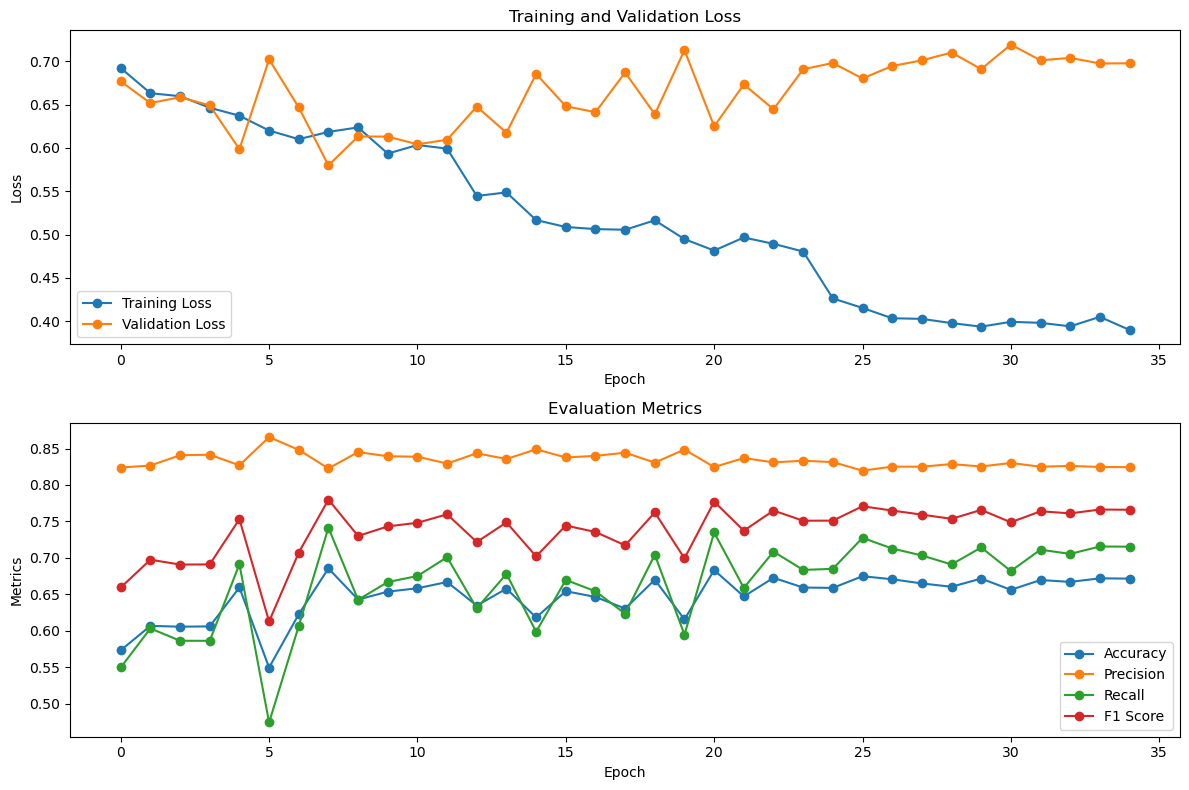

In [21]:
import matplotlib.pyplot as plt


epochs = [i for i in range(len(val_loss))]
train_loss = [train_loss[i*4] for i in range(len(val_loss))]


# Plot the metrics
plt.figure(figsize=(12, 8))

# Loss Plot
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, label="Training Loss", marker='o')
plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Metrics Plot
plt.subplot(2, 1, 2)
plt.plot(epochs, accuracy, label="Accuracy", marker='o')
plt.plot(epochs, precision, label="Precision", marker='o')
plt.plot(epochs, recall, label="Recall", marker='o')
plt.plot(epochs, f1, label="F1 Score", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.title("Evaluation Metrics")
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
def preprocess_text(text):
    """Clean and preprocess text"""
    # Convert to lowercase
    text = text.lower()
    # Remove multiple spaces
    text = ' '.join(text.split())
    # Remove special characters but keep punctuation
    text = ''.join([c if c.isalnum() or c.isspace() or c in '.,!?' else ' ' for c in text])
    return text


def predict_verdict(text, model, tokenizer):
    """Predict verdict with preprocessing"""
    # Preprocess text
    clean_text = preprocess_text(text)

    # Add special tokens
    text_with_tokens = f"[TITLE] {clean_text}"

    # Tokenize
    inputs = tokenizer(
        text_with_tokens,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move to GPU if available
    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}
        model = model.to("cuda")

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][prediction].item()

    return prediction, confidence

In [23]:
def aita_classifier(text, model, tokenizer):
    prediction, confidence = predict_verdict(text, model, tokenizer)
    verdict = "NTA" if prediction == 1 else "YTA"
    print(f"Verdict: {verdict} (confidence: {confidence:.2f})")

    return verdict, confidence


In [24]:
# https://www.reddit.com/r/AmItheAsshole/comments/1gwl76e/aitah_for_refusing_to_let_my_moms_boyfriend_walk/
text = """AITAH for refusing to let my mom’s boyfriend walk me down the aisle?

I (24F) am getting married next summer, and ever since I started planning the wedding, my mom (48F) has been pushing for her boyfriend (50M) to walk me down the aisle. My dad passed away when I was 10, and my mom started dating her boyfriend about six years ago. While he’s always been nice to me, I’ve never seen him as a father figure, he came into my life when I was already an adult, and we’re friendly but not particularly close.

I told my mom that I plan to walk myself down the aisle as a way to honor my independence and my dad’s memory. She got really upset, saying her boyfriend has “earned” the spot by being there for me all these years. She even accused me of disrespecting her relationship and trying to “erase” my dad, which couldn’t be further from the truth.

Now her boyfriend is avoiding me, and my mom keeps calling me selfish and saying I’m ruining the wedding before it even starts. A few family members are also weighing in, saying I should let him do it to keep the peace. But this is my wedding, and I feel like I should have the final say. AITAH?"""

verdict, confidence = aita_classifier(text, model, tokenizer)

Verdict: NTA (confidence: 0.91)


In [25]:
# https://www.reddit.com/r/AmItheAsshole/comments/1gw9o5g/aita_for_defending_my_daughters_comments_towards/
text = """AITA for defending my daughters comments towards my other daughter being single?

My daughter (17f, Emily) has been dating this boy (17m, Zach) for around 2 -2 1/2 months now and he recently came to visit us, and this is the first time he has came over for dinner, and this is Emilys first bf. Zach is a very lovely boy and very outgoing. When he came in and saw me he says "Emily, I didn't know you have 2 sisters". I laughed as even though it's cliche I know he's trying to be nice. The entire time at dinner he was very polite but he is also a very outgoing kid. He would say stuff such as what a lovely dinner, this food is great, your backyard is beautiful, etc, etc. So while you could say he was trying to be overly polite, he was still a very sweet and kind kid. Emily is a more shy and reserved person so I felt they were really great for each other. Emily is also very sweet and positive, another thing they have in common that I appreciated. My husband also hit it off with him and they were engaging in sports banter, and eventually came to trash talking some football team owner.

My older daughter (amy,19), however kept grilling the poor guy. Asking if he would pay for dates, to which he said yeah, and then she asks how he has money, and he said his job, then she started talking about making time for Emily, in between school friends and a job. Then it came onto how they would get to dates and she started asking him about his license, she then started to ask about protecting her making comments on his stature (hes on the shorter side and kind of chubby, like 5'7 and maybe a little overweight, nothing crazy however) and he seemed to be getting uncomfortable so I brought out dessert, which he again complimented, and my husband brought up sports to change topics.

After he left I asked her why she would do that. She said that he seemed to nice, and cliche, as if he was faking it. I said so people cant be nice these days? You made it weird for him and Emily, Emily didn't deserve that neither did he. She said that she just didn't like that vibe as no-one is that nice or positive it was definetely forced. Emily butted in and said that she really didnt appreciate that and said that Amy's reasoning didn't make sense. Amy said that she didn't care if it was awkward as she wanted to grill him, and that she doesn't like him because he seemed fake. Emily said, that Amy was messed up and I agreed. Amy then said that he was some dumb weak kid faking being nice, and this upset Emily, and me. Emily then said in a fuss "You only say that because your single and no one will date you". She has been slightly sensitive about this as she hasn't been in a committed relationship yet.This upset Amy and Amy asked why I didn't say anything or stop her from going to her room. I said that she just insulted her bf and that she deserved it, she told me I should punish her and was being a bad parent and now Amy isn't talking to me and I feel that maybe a personal insult like that was to far."""

verdict, confidence = aita_classifier(text, model, tokenizer)

Verdict: YTA (confidence: 0.73)


In [26]:
model.save_pretrained('../models/fine_tuned_aita_classifier')